In [76]:
import pandas as pd
import mysql.connector

from IPython.display import display, Markdown

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.date, event_log.actor_id,
        user.username, event_log.event_id, event.name
        from event_log
        join event on event.id = event_log.event_id
        join user on user.id = event_log.actor_id
        order by event_log.id
    """, db)
    df.set_index("id", inplace=True)
    
    return delete_consecutive_events(df)

def delete_consecutive_events(df):
    df.sort_values(["actor_id", "date"], inplace=True)
    df["time_diff_seconds"] = df["date"].diff().map(lambda x: x.total_seconds())
    
    to_delete = (df["time_diff_seconds"] >= 0) & (df["time_diff_seconds"] < 3)
    df.drop(df[to_delete].index, inplace=True)
    
    return df

event_log = read_event_log()
event_log.tail(100)

,date,actor_id,username,event_id,name,time_diff_seconds
id,,,,,,
378277,2021-03-09 08:01:34,197401,Annika-Hemlein,5,entity/revision/add,8.0
378278,2021-03-09 08:01:41,197401,Annika-Hemlein,5,entity/revision/add,7.0
378281,2021-03-09 08:44:48,197401,Annika-Hemlein,5,entity/revision/add,2587.0
378287,2021-03-09 08:44:52,197401,Annika-Hemlein,5,entity/revision/add,4.0
378291,2021-03-09 08:45:00,197401,Annika-Hemlein,5,entity/revision/add,8.0
...,...,...,...,...,...,...
379200,2021-03-10 16:04:17,198070,Ryker,9,discussion/comment/create,-58325.0
379212,2021-03-10 20:34:46,198102,Vater,8,discussion/create,16229.0
379231,2021-03-11 08:11:54,198102,Vater,9,discussion/comment/create,41828.0


In [77]:
from IPython.display import display, HTML
style = """
    <style>
        .output_scroll {
            height: unset !important;
            border-radius: unset !important;
            -webkit-box-shadow: unset !important;
            box-shadow: unset !important;
        }
    </style>
    """
display(HTML(style))

In [90]:
community = pd.read_csv("community.csv")
community.set_index("username", inplace=True)
display(community)

,actor_id,edits,team_or_ex-team,member_convo,member_academy,teacher,teacher_student,age,bundesland
username,,,,,,,,,
kathongi,73435,5207,1.0,1,1.0,0.0,1.0,NaN,Bayern
WandaPaetzold,146133,3337,1.0,1,1.0,0.0,1.0,NaN,Bayern
Karin,87602,3187,1.0,0,0.0,0.0,0.0,NaN,Bayern
chdieter,53589,2776,0.0,0,0.0,1.0,1.0,NaN,Bayern
metzgaria,70932,2184,1.0,0,1.0,1.0,1.0,NaN,Bayern
...,...,...,...,...,...,...,...,...,...
kurrater,63268,60,NaN,0,NaN,NaN,NaN,NaN,NaN
dems15v1,134769,59,0.0,0,0.0,NaN,NaN,NaN,NaN
I_M_MEEN,131533,56,NaN,0,NaN,NaN,NaN,NaN,NaN


In [97]:
def is_not_team(username):
    return username not in community.index or community.loc[username]["team_or_ex-team"] != 1

display(is_not_team("kathongi"))
display(is_not_team("chdieter"))
display(is_not_team("kurrater"))
display(is_not_team("arekkas"))

False

True

True

True

In [78]:
def compute_edits_per_day_per_user(df, event_ids=[5], since=4*365.25):
    current_date = df["date"].max()
    df = df[df["date"] > current_date - pd.Timedelta(days=since)]
    df = df[df["event_id"].isin(event_ids)]
    
    def user_df(username):
        #display(df.head())
        u = df[df["username"] == username].copy()
        u.set_index("date", inplace=True)
        u = u.resample("D").count()[["actor_id"]]
        u.rename(columns={"actor_id": username}, inplace=True)
        return u
    
    df = pd.concat([user_df(u) for u in df["username"].unique()], axis=1)
    df.fillna(0, inplace=True)
    
    return df

compute_edits_per_day_per_user(event_log)

,arekkas,Deleted,Simon,HokkaidokÃƒÂ¼rbis,Sophia,Renate,Laura,Hannes,Tinsaye,pinkmuffin,...,Wo_Fo,Anton_Zikmund,Mathes,Katrin_K,Matheo,KerstinPecher,reallpk,Rami,Gianluca,Annika-Hemlein
date,,,,,,,,,,,,,,,,,,,,,
2017-03-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-15,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0
2021-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,9.0,13.0,0.0,0.0,14.0,1.0,34.0
2021-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,20.0,0.0,0.0,17.0,6.0,65.0


```
+----+-----------------------------+-------------+
| id | name                        | description |
+----+-----------------------------+-------------+
|  1 | taxonomy/term/associate     | NULL        |
|  2 | taxonomy/term/create        | NULL        |
|  3 | license/object/set          | NULL        |
|  4 | entity/create               | NULL        |
|  5 | entity/revision/add         | NULL        |
|  6 | entity/revision/checkout    | NULL        |
|  7 | entity/link/create          | NULL        |
|  8 | discussion/create           | NULL        |
|  9 | discussion/comment/create   | NULL        |
| 10 | uuid/trash                  | NULL        |
| 11 | entity/revision/reject      | NULL        |
| 12 | taxonomy/term/update        | NULL        |
| 13 | uuid/restore                | NULL        |
| 14 | discussion/comment/archive  | NULL        |
| 15 | taxonomy/term/parent/change | NULL        |
| 16 | discussion/restore          | NULL        |
| 17 | taxonomy/term/dissociate    | NULL        |
| 18 | entity/link/remove          | NULL        |
+----+-----------------------------+-------------+
```

In [79]:
event_types = {
    "Inhalt": [5,6],
    "Kommentare": [8,9,14,16],
    "Reviewing": [6,11],
    "Taxonomy": [1,2,12,15,17],
    "Administration": [10,13,3]
}
event_types["Inhalt + Taxonomy"] = event_types["Inhalt"] + event_types["Taxonomy"]

In [80]:
def compute(df, func=lambda data: data[:int(len(data)/2)].sum(),
            event_ids = [5,6], time_interval=90):
    df = compute_edits_per_day_per_user(df, event_ids)
    df = df.rolling(2*time_interval, min_periods=2*time_interval,
                    center=True).aggregate(func)
    df.dropna(inplace=True)
    
    return df

left = dict()
right = dict()

for event_type, event_ids in event_types.items():
    print(f"Pre-Compute: {event_type}")
    left[event_type] = compute(event_log, event_ids = event_ids)
    right[event_type] = compute(event_log, event_ids = event_ids,
                                func=lambda data: data[int(len(data)/2):].sum())

Pre-Compute: Inhalt
Pre-Compute: Kommentare
Pre-Compute: Reviewing
Pre-Compute: Taxonomy
Pre-Compute: Administration
Pre-Compute: Inhalt + Taxonomy


In [113]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

from scipy.stats import zscore
from IPython.display import display, Markdown
from ipywidgets import interact, interact_manual

def plot_conversion(target_number=10, target_operant="Aktivierung", event_type="Inhalt", with_team=True, since_years=4):
    target_number = int(target_number)
    
    is_right = lambda e: e >= target_number
    
    if target_operant == "Aktivierung":
        is_left = lambda e: e != 0 and not is_right(e)
    else:
        is_left = is_right
    
    def compute_conversion(data, func):
        def is_left_to_right(data):
            if not data[0]:
                return None
            if data[1]:
                return 1
            
            return 0
        
        left = data[:int(len(data)/2)].map(is_left)
        right = data[int(len(data)/2):].map(is_right)
        
        results = [is_left_to_right(data) for data in zip(left, right)]
        results = [r for r in results if r != None]
        
        if len(results) == 0:
            return np.nan
        else:
            return func(results)
    
    def show(data, ylim_plus=1):
        display(Markdown("### Plot"))
        data.plot(figsize=(20,10), ylim=(0, data.max()+ylim_plus))
        plt.show()

        display(Markdown("### Beschreibung"))
        
        current = data[-1]
        before_one_year = data[-365]

        display(Markdown(f"Current: {current}"))
        display(Markdown(f"Before one year: {before_one_year}"))
        display(data.describe())
    
    def get_df(base):
        df = base[event_type]
        
        if not with_team:
            return df[[c for c in df.columns if is_not_team(c)]]
        else:
            return df
    
    df = pd.concat([get_df(left), get_df(right)], axis=1)
    df = df[df.index > df.index.max() - pd.Timedelta(days=int(since_years)*365.25)]

    relative = df.apply(lambda x: compute_conversion(x, lambda r: sum(r) / len(r)), axis=1)
    absolute = df.apply(lambda x: compute_conversion(x, lambda r: sum(r)), axis=1)
    potential = df.apply(lambda x: compute_conversion(x, lambda r: len(r)), axis=1)
    
    display(Markdown("## Relative Übergangsrate"))
    show(relative, ylim_plus=0.1)
    
    display(Markdown("## Absolute Übergangsrate"))
    show(absolute)
    
    display(Markdown("## Gesamtzahl Autor:innen in der Ausgangsmenge (=Potential)"))
    show(potential)
    
    #display(Markdown("## Vergleich Relative / Potential"))
    #pd.DataFrame({ "relative": relative / relative.max(), "potential": potential / potential.max() }).plot(figsize=(20,10))
    #plt.show()
    
    display(Markdown("## Vergleich Relative / Potential (z-score)"))
    df2 = pd.DataFrame({ "relative": relative, "potential": potential })
    df2.dropna().apply(zscore).plot(figsize=(20,10))
    plt.show()
    display(Markdown("### Korrelation"))
    display(df2.corr())
    
interact_manual(plot_conversion, target_number="10",
                target_operant=["Aktivierung", "Halten"],
                event_type=event_types.keys(),
                with_team=True, since_years="4")

interactive(children=(Text(value='10', description='target_number'), Dropdown(description='target_operant', op…

<function __main__.plot_conversion(target_number=10, target_operant='Aktivierung', event_type='Inhalt', with_team=True, since_years=4)>

# Aktivierungsrate <10 -> >= 10 konstant und auf niedriegen Niveau

## Relative Übergangsrate

### Plot

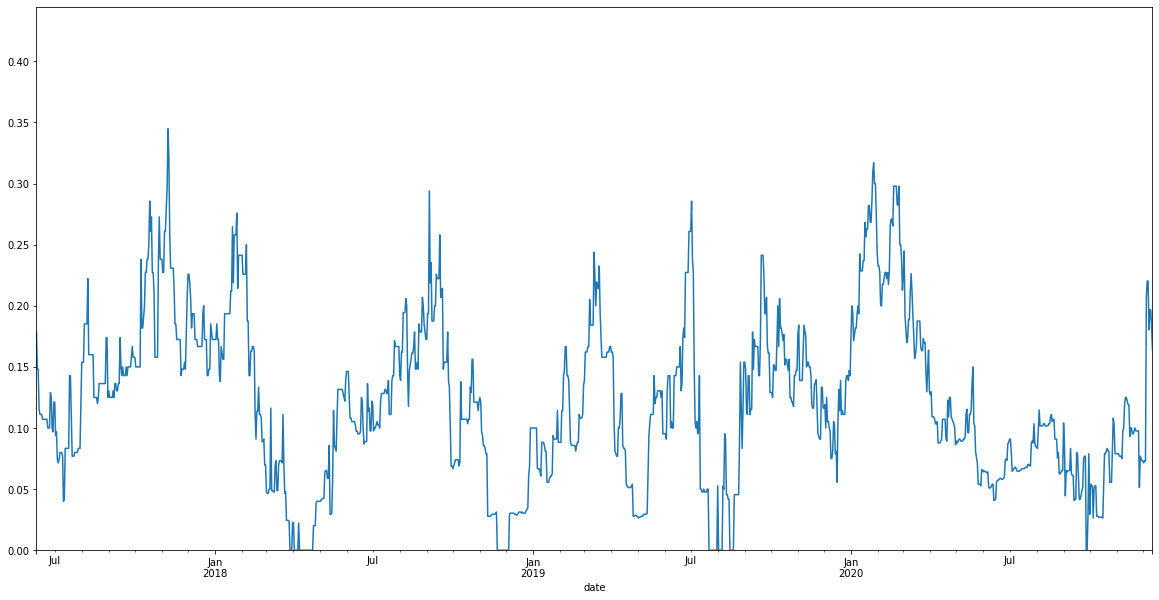

### Beschreibung

Current: 0.16393442622950818

Before one year: 0.07894736842105263

count    1282.000000
mean        0.119893
std         0.066608
min         0.000000
25%         0.073171
50%         0.111111
75%         0.162162
max         0.344828
dtype: float64

## Absolute Übergangsrate

### Plot

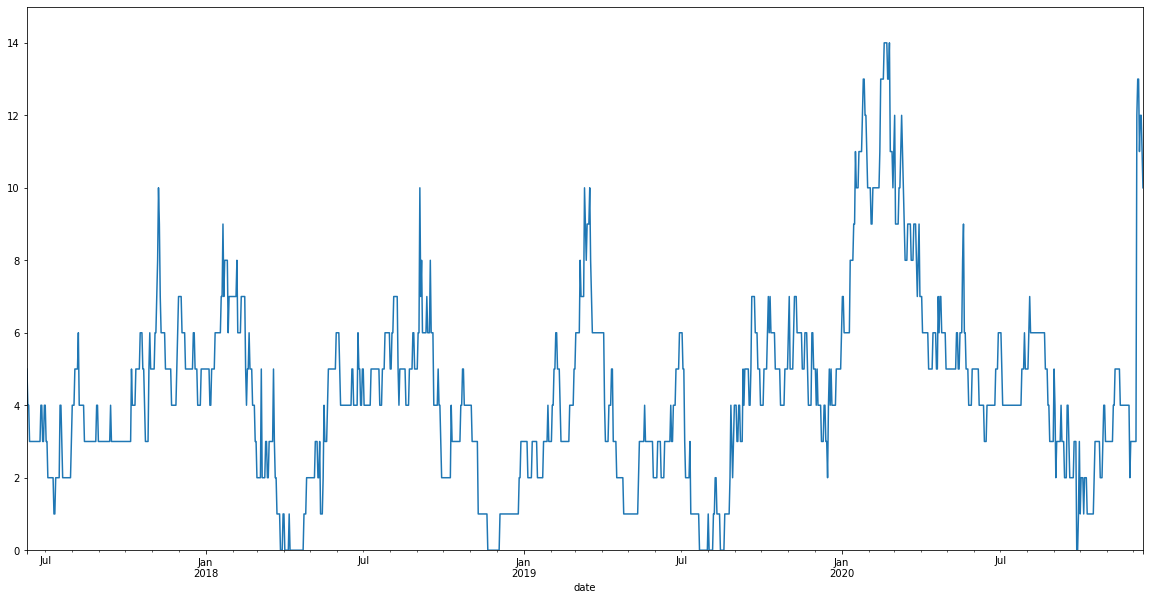

### Beschreibung

Current: 10

Before one year: 3

count    1282.000000
mean        4.287051
std         2.536289
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        14.000000
dtype: float64

## Gesamtzahl Autor:innen in der Ausgangsmenge (=Potential)

### Plot

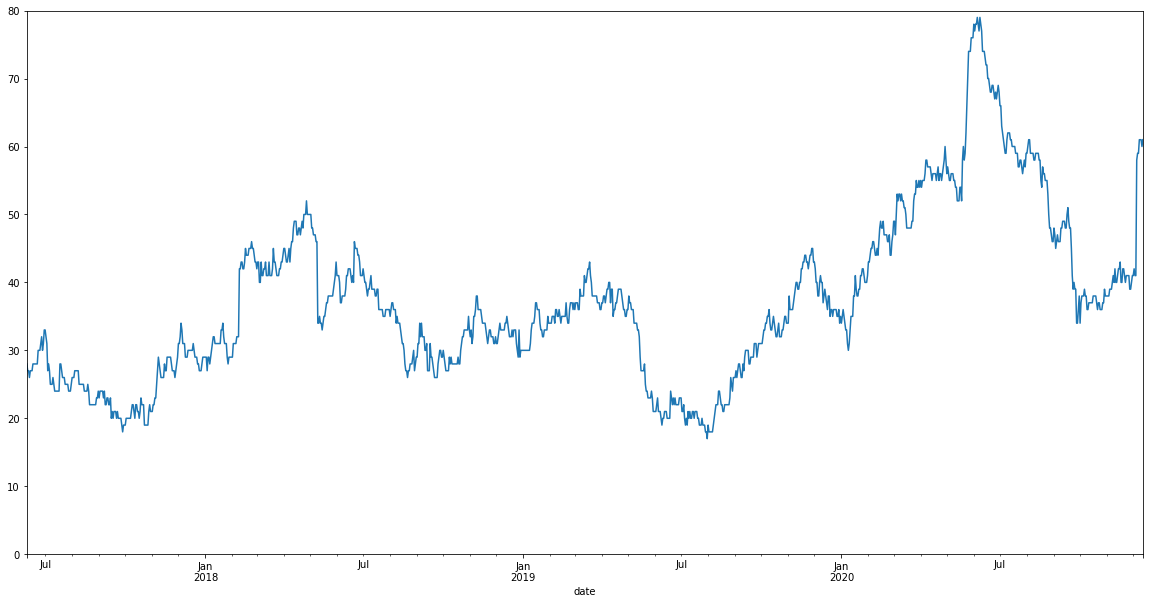

### Beschreibung

Current: 61

Before one year: 38

count    1282.000000
mean       37.086583
std        12.175512
min        17.000000
25%        28.000000
50%        35.000000
75%        43.000000
max        79.000000
dtype: float64

## Vergleich Relative / Potential (z-score)

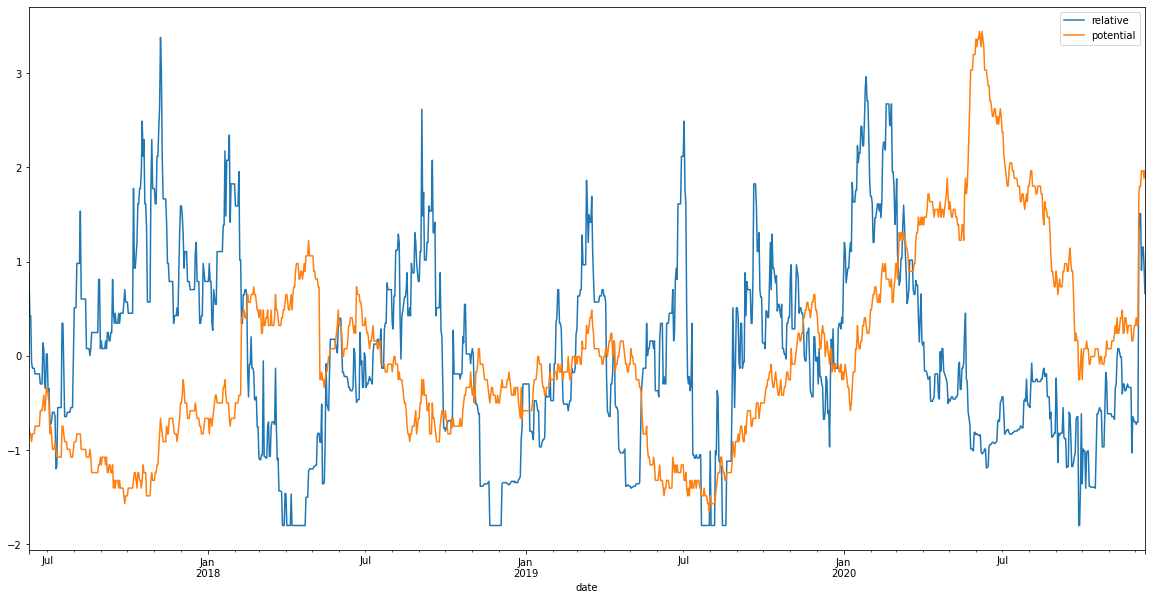

### Korrelation

,relative,potential
relative,1.000000,-0.196655
potential,-0.196655,1.000000


In [120]:
plot_conversion(target_operant="Aktivierung")

# Halten-Rate gut bei niedriegen Niveau, bei hohem Niveau kann es besser sein (Problem: Academy + Praktikum)

## Relative Übergangsrate

### Plot

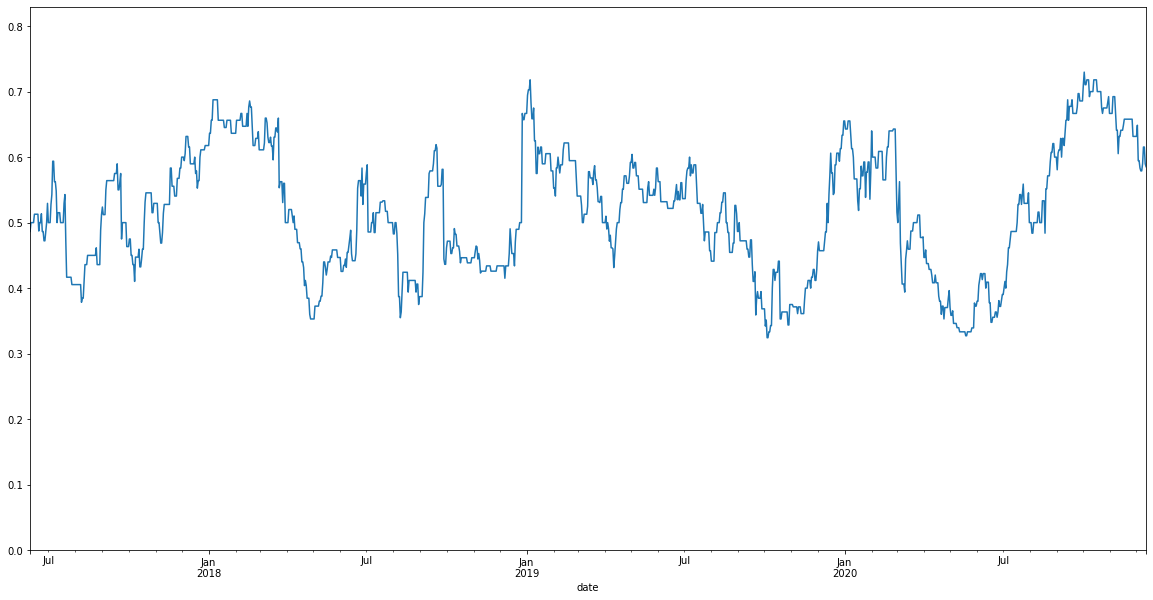

### Beschreibung

Current: 0.5853658536585366

Before one year: 0.5428571428571428

count    1282.000000
mean        0.516244
std         0.094128
min         0.324324
25%         0.441176
50%         0.515152
75%         0.588235
max         0.729730
dtype: float64

## Absolute Übergangsrate

### Plot

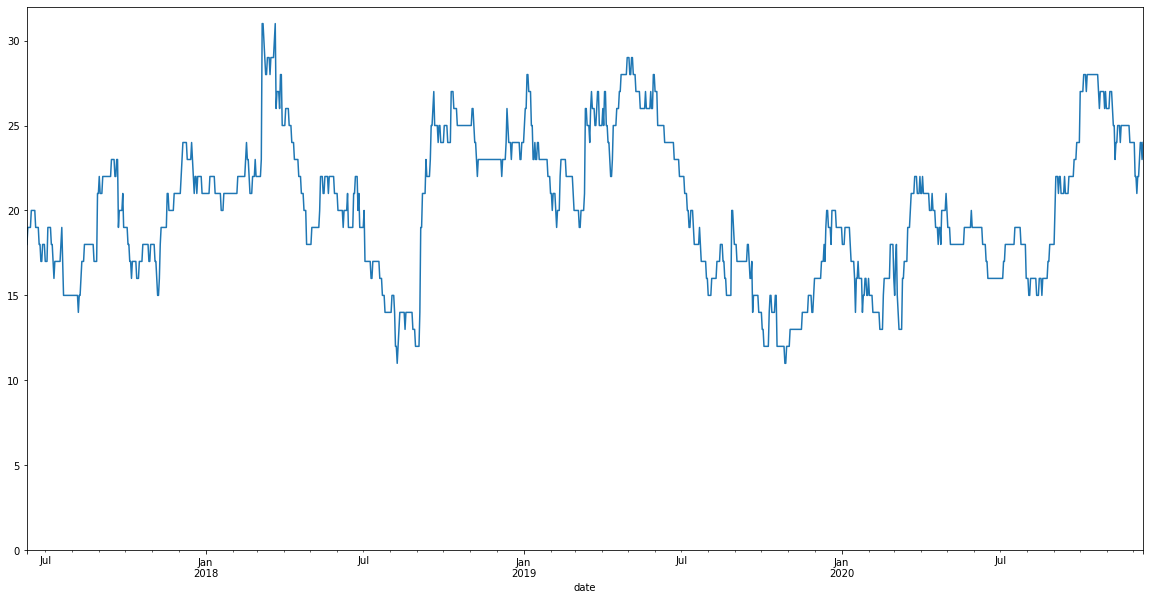

### Beschreibung

Current: 24

Before one year: 19

count    1282.000000
mean       20.180187
std         4.161961
min        11.000000
25%        17.000000
50%        20.000000
75%        23.000000
max        31.000000
dtype: float64

## Gesamtzahl Autor:innen in der Ausgangsmenge (=Potential)

### Plot

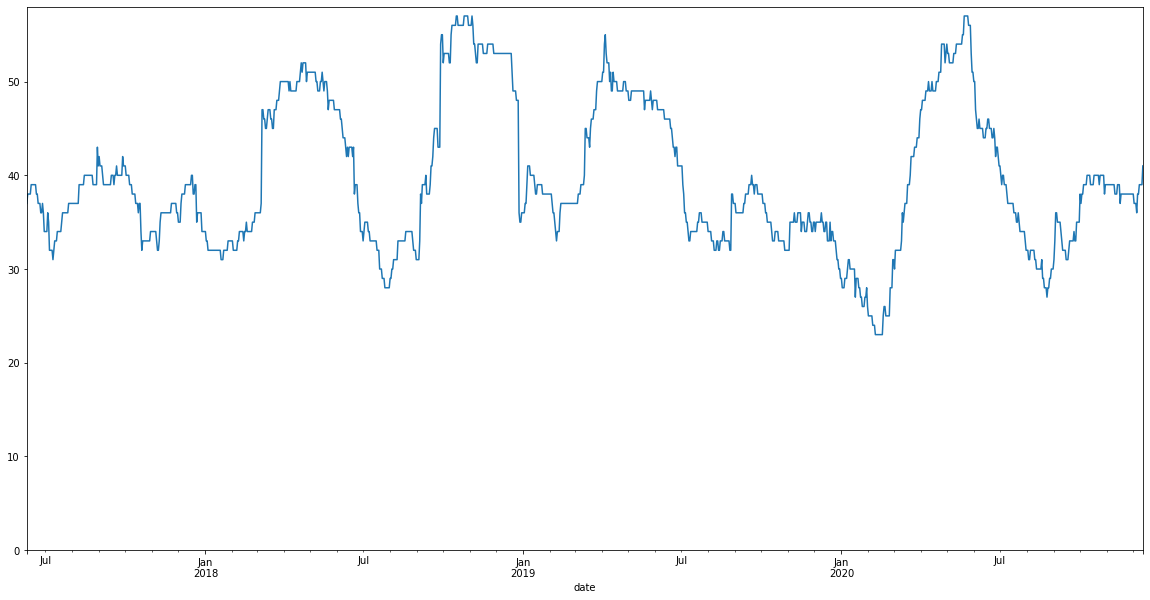

### Beschreibung

Current: 41

Before one year: 35

count    1282.000000
mean       39.637285
std         7.758169
min        23.000000
25%        34.000000
50%        38.000000
75%        46.000000
max        57.000000
dtype: float64

## Vergleich Relative / Potential (z-score)

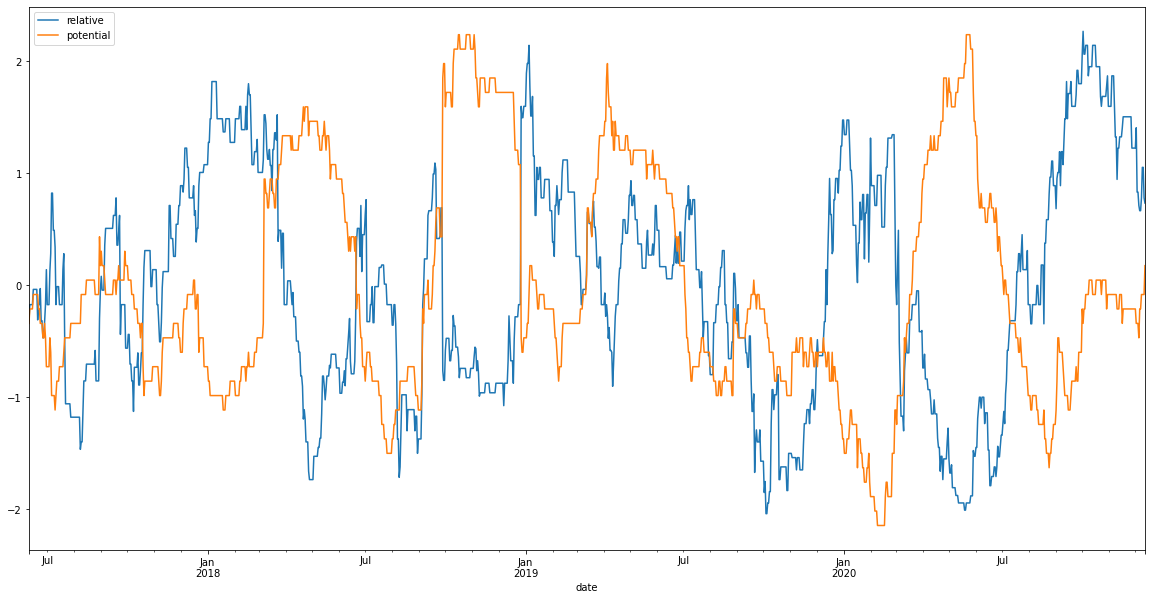

### Korrelation

,relative,potential
relative,1.000000,-0.386893
potential,-0.386893,1.000000


In [115]:
plot_conversion(target_operant="Halten")

# Vergleich: Halten und with_team=False

## Relative Übergangsrate

### Plot

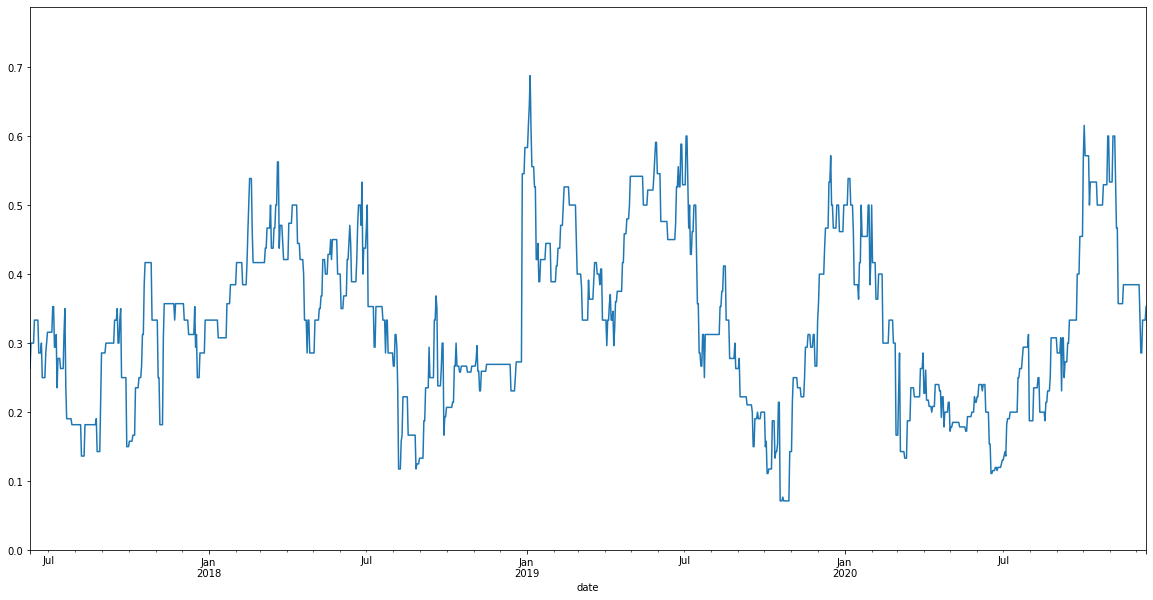

### Beschreibung

Current: 0.35294117647058826

Before one year: 0.5333333333333333

count    1282.000000
mean        0.329066
std         0.120152
min         0.071429
25%         0.235294
50%         0.312500
75%         0.416667
max         0.687500
dtype: float64

## Absolute Übergangsrate

### Plot

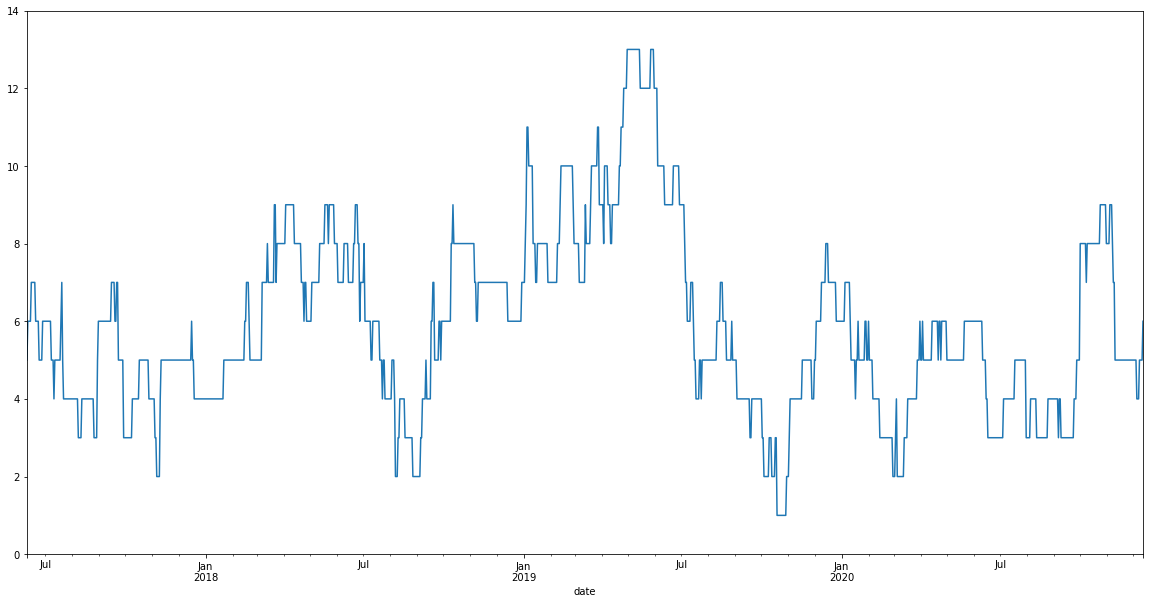

### Beschreibung

Current: 6

Before one year: 8

count    1282.000000
mean        5.868955
std         2.335950
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        13.000000
dtype: float64

## Gesamtzahl Autor:innen in der Ausgangsmenge (=Potential)

### Plot

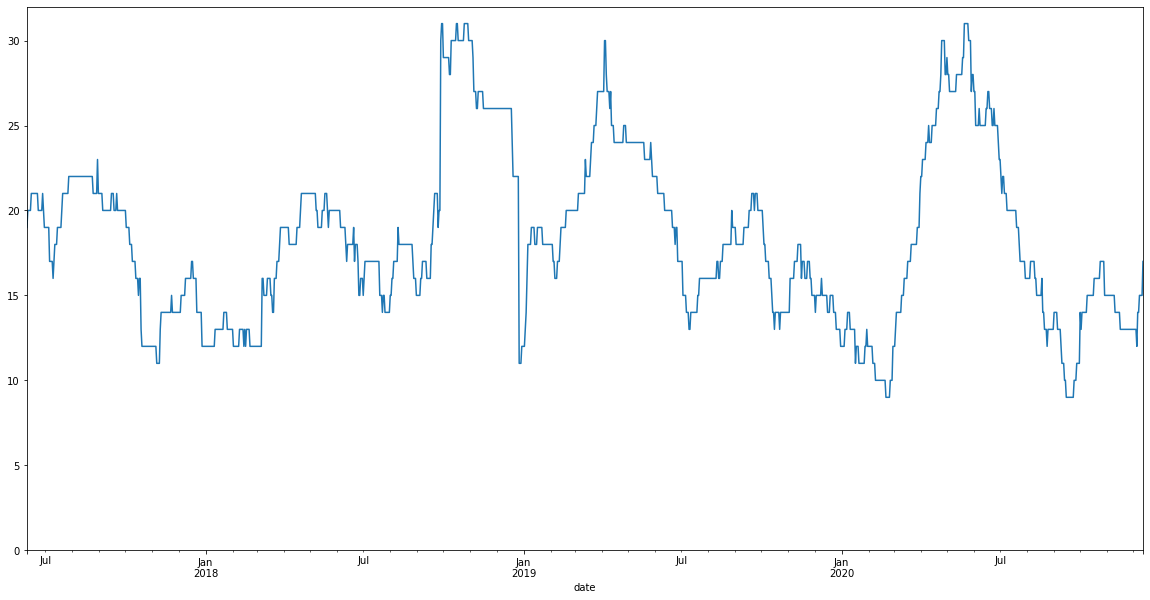

### Beschreibung

Current: 17

Before one year: 15

count    1282.000000
mean       18.352574
std         5.036218
min         9.000000
25%        14.000000
50%        18.000000
75%        21.000000
max        31.000000
dtype: float64

## Vergleich Relative / Potential (z-score)

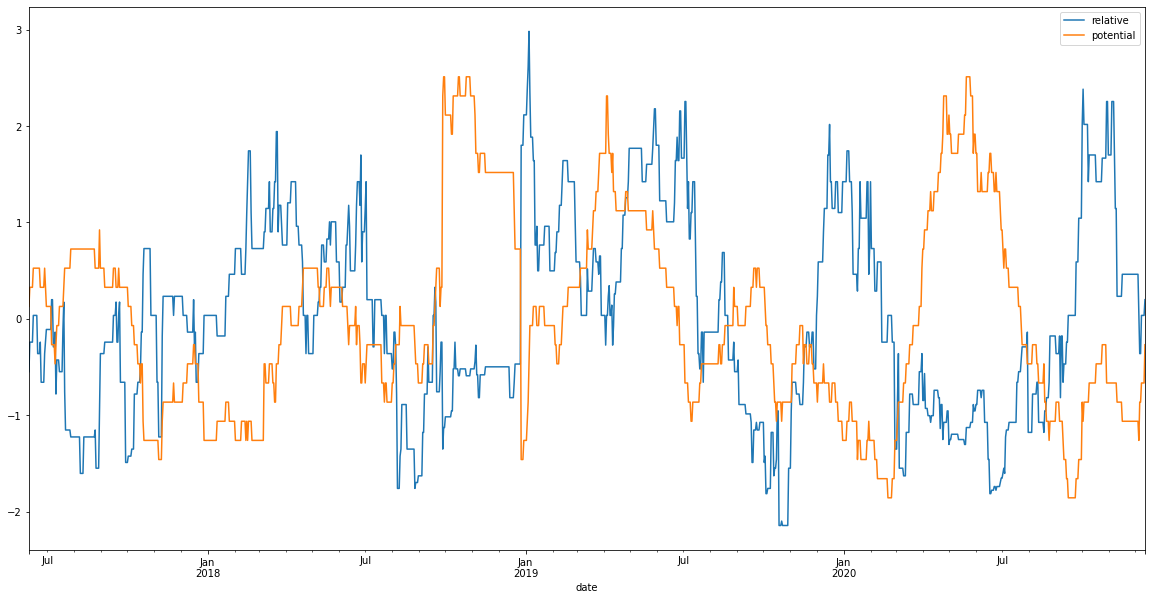

### Korrelation

,relative,potential
relative,1.000000,-0.281583
potential,-0.281583,1.000000


In [116]:
plot_conversion(target_operant="Halten", with_team=False)

# Aktuell besser sehr aktive Autor:innen zu halten

## Relative Übergangsrate

### Plot

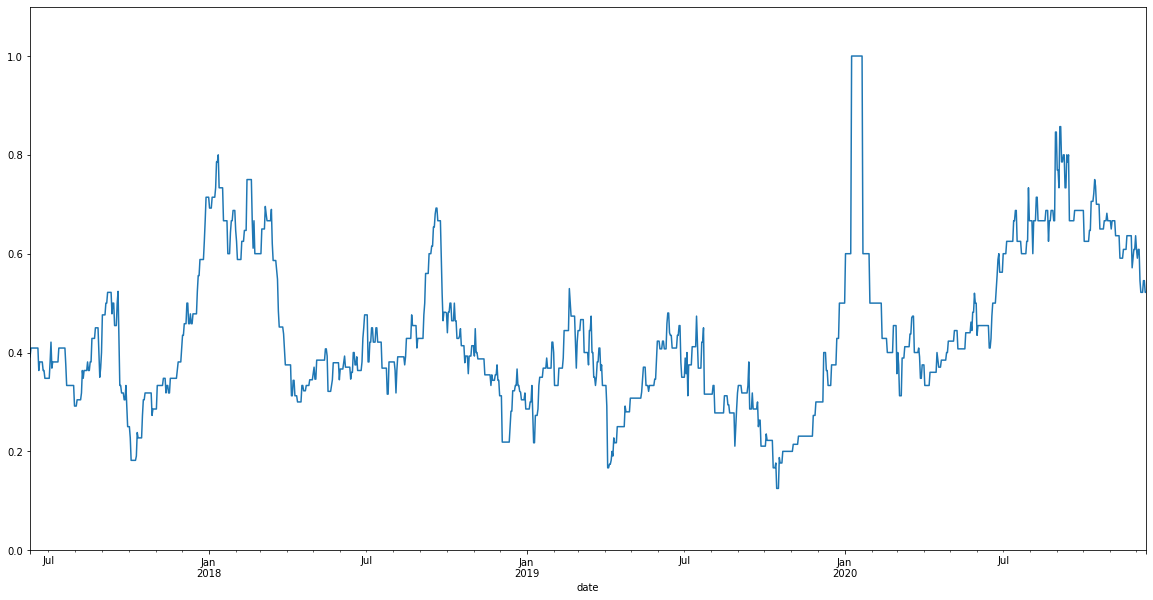

### Beschreibung

Current: 0.5217391304347826

Before one year: 0.3333333333333333

count    1282.000000
mean        0.436673
std         0.154000
min         0.125000
25%         0.333333
50%         0.400000
75%         0.519630
max         1.000000
dtype: float64

## Absolute Übergangsrate

### Plot

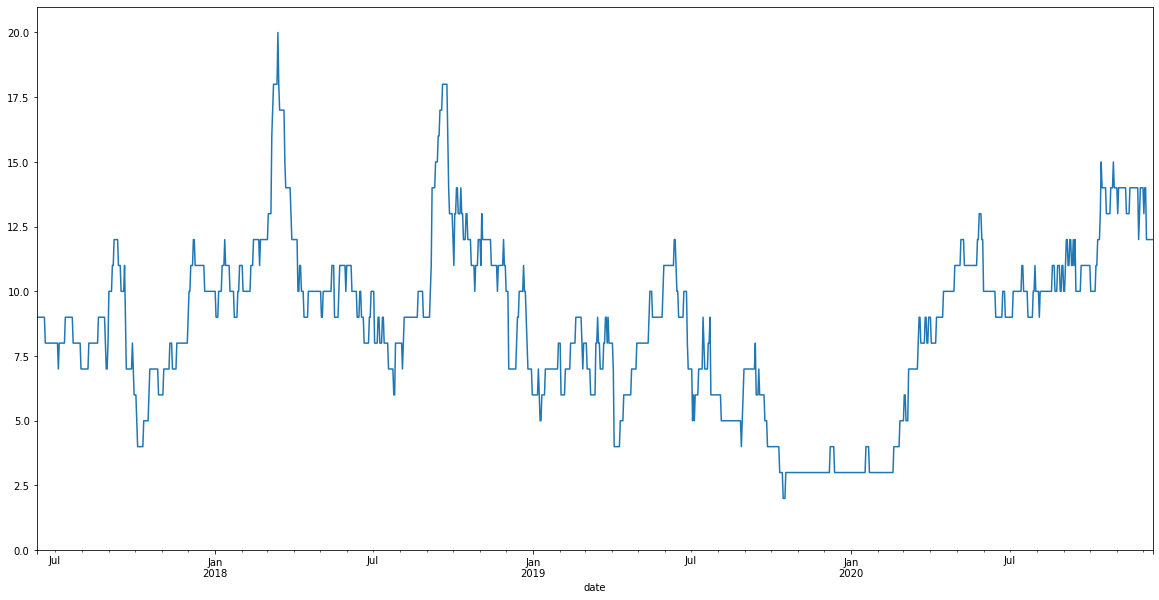

### Beschreibung

Current: 12

Before one year: 3

count    1282.000000
mean        8.674727
std         3.194863
min         2.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        20.000000
dtype: float64

## Gesamtzahl Autor:innen in der Ausgangsmenge (=Potential)

### Plot

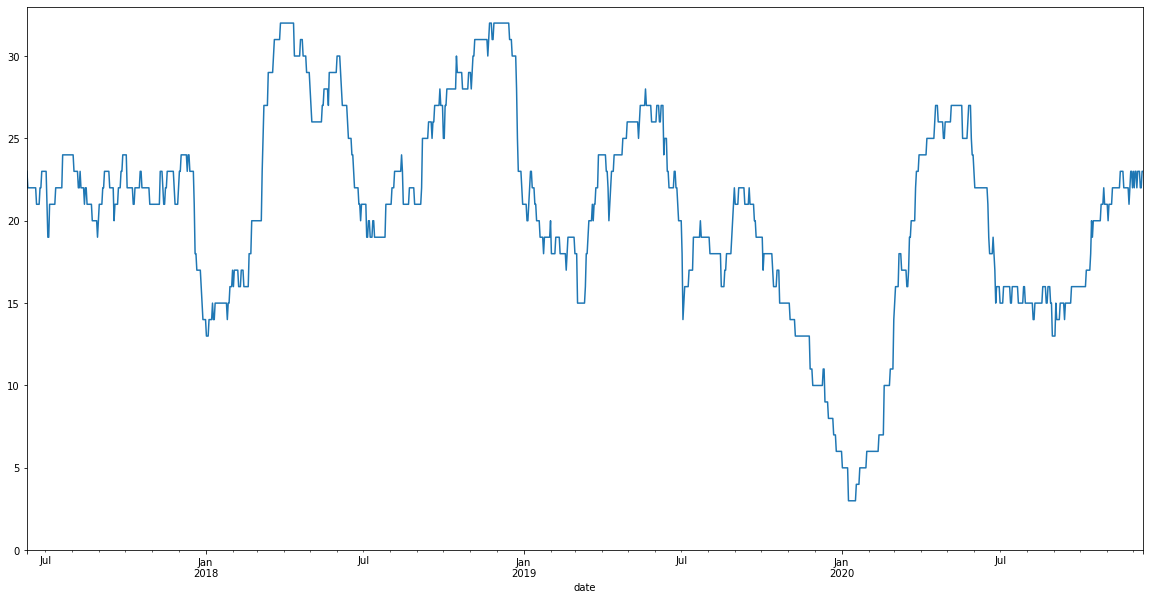

### Beschreibung

Current: 23

Before one year: 9

count    1282.000000
mean       20.617005
std         6.051364
min         3.000000
25%        17.000000
50%        21.000000
75%        24.000000
max        32.000000
dtype: float64

## Vergleich Relative / Potential (z-score)

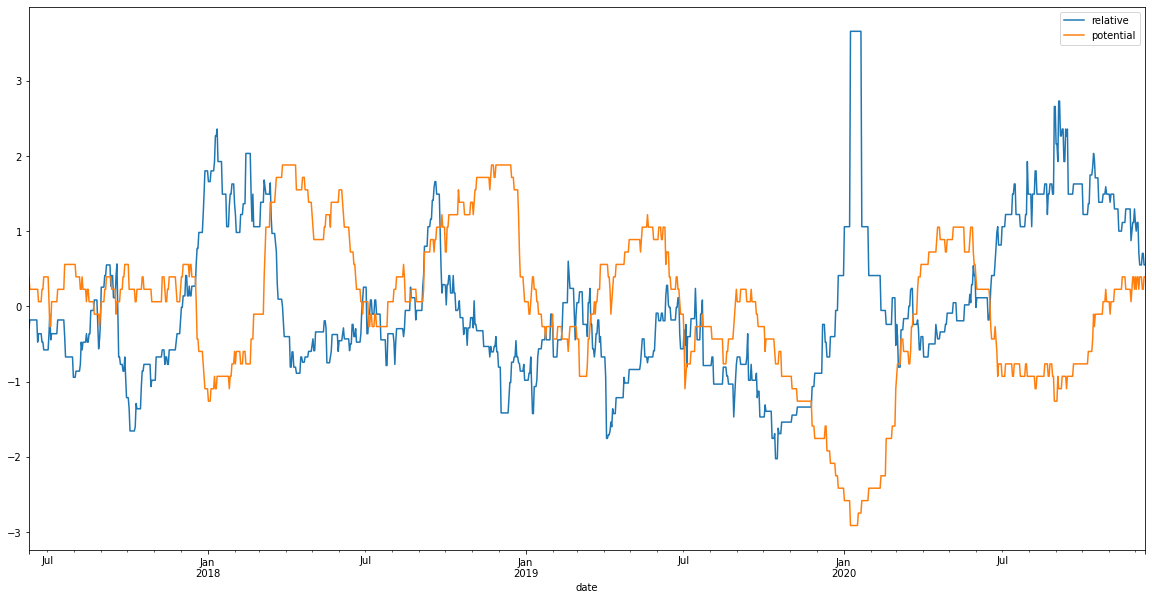

### Korrelation

,relative,potential
relative,1.000000,-0.352407
potential,-0.352407,1.000000


In [118]:
plot_conversion(target_operant="Halten", target_number=50)

# Aktivierung zu sehr aktiv eher gering

## Relative Übergangsrate

### Plot

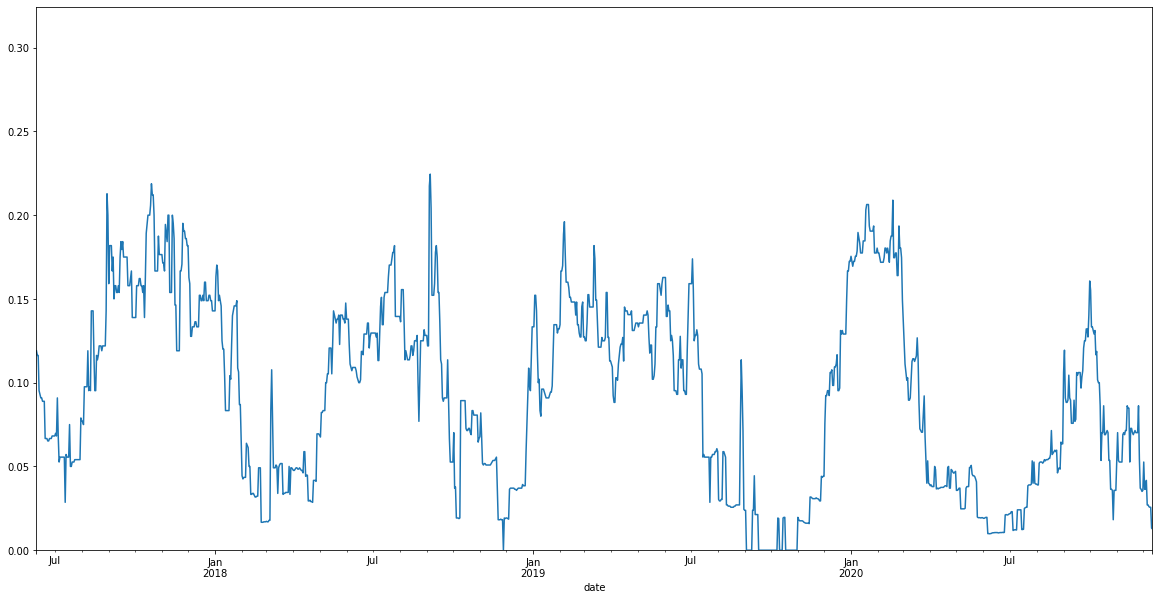

### Beschreibung

Current: 0.012658227848101266

Before one year: 0.109375

count    1282.000000
mean        0.092017
std         0.055506
min         0.000000
25%         0.042784
50%         0.092308
75%         0.137539
max         0.224490
dtype: float64

## Absolute Übergangsrate

### Plot

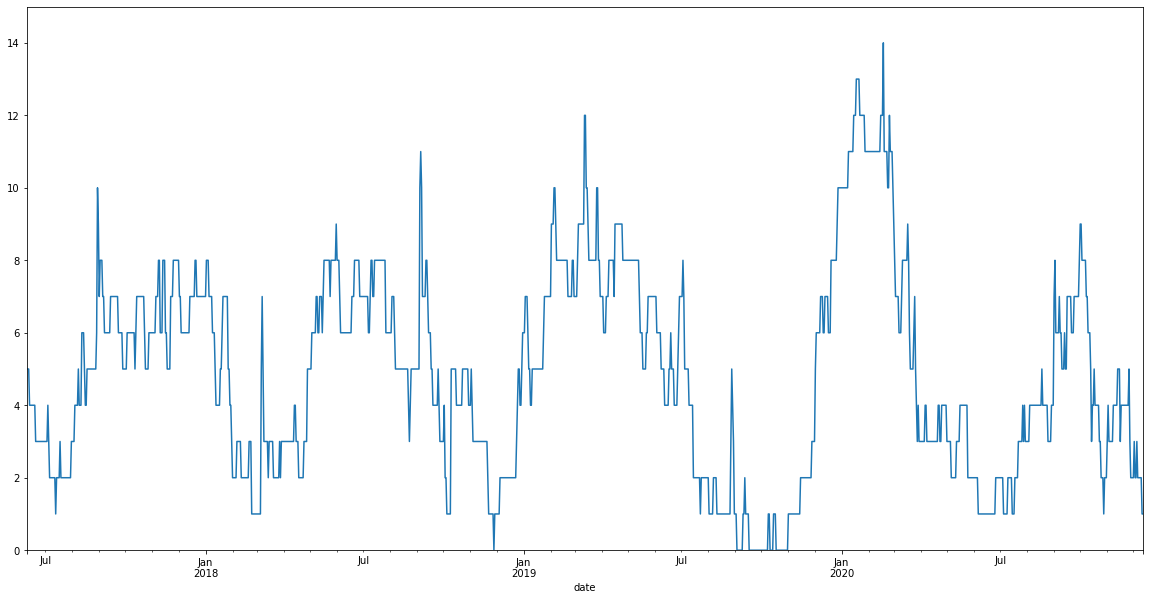

### Beschreibung

Current: 1

Before one year: 7

count    1282.000000
mean        4.863495
std         2.848656
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        14.000000
dtype: float64

## Gesamtzahl Autor:innen in der Ausgangsmenge (=Potential)

### Plot

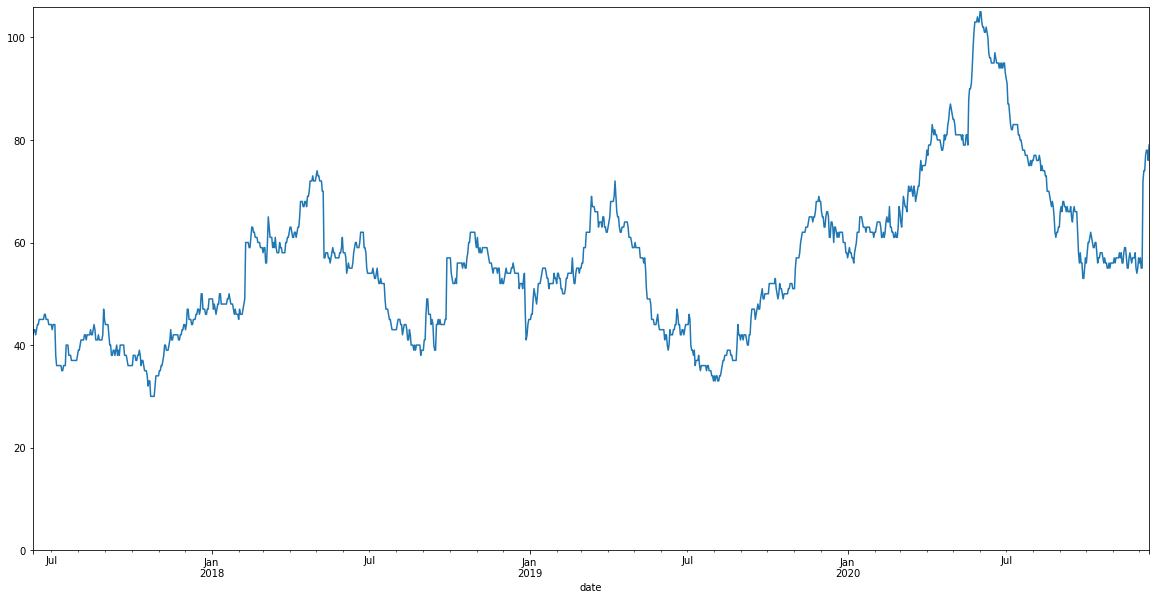

### Beschreibung

Current: 79

Before one year: 64

count    1282.000000
mean       56.106864
std        14.443147
min        30.000000
25%        44.000000
50%        56.000000
75%        63.000000
max       105.000000
dtype: float64

## Vergleich Relative / Potential (z-score)

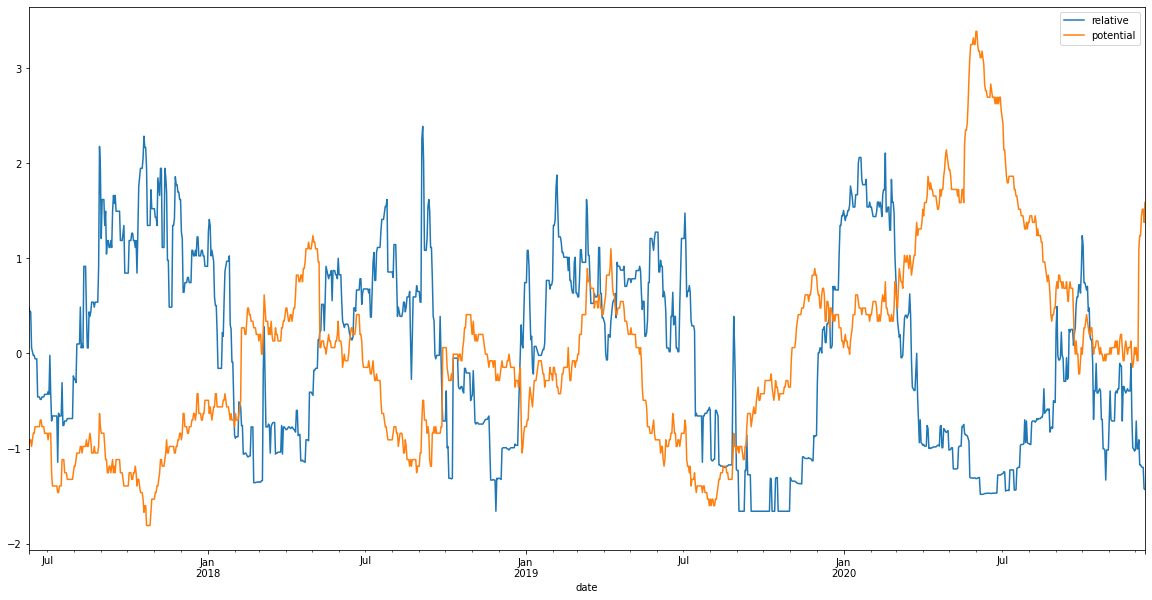

### Korrelation

,relative,potential
relative,1.000000,-0.373652
potential,-0.373652,1.000000


In [119]:
plot_conversion(target_operant="Aktivierung", target_number=50)